In [57]:
from selenium import webdriver
from time import sleep
import matplotlib.pyplot as plt
from datetime import date
from math import ceil
from collections import Counter

In [ ]:
browser = webdriver.Chrome('/home/order/Videos/chromedriver/chromedriver')
find_css = browser.find_element_by_css_selector
find_xpath = browser.find_element_by_xpath
browser.implicitly_wait(5) # For page loading waiting (w/o dynamic elements)
browser.get('https://www.gmail.com')
### 0. Gmail signin
sign_in_button = find_xpath('/html/body/nav/div/a[2]')
sign_in_button.click()
sleep(2)
### 1. Google login
user_1 = find_css('#identifierId')
user_1.send_keys('snore001@ucr.edu') ### YOUR EMAIL HERE
sleep(1)
submit_1 = find_css('#identifierNext')
submit_1.click()
### 2. UCR login
user_2 = find_css('#username')
user_2.send_keys('') ### YOUR UCR USERNAME HERE
pass_2 = find_css('#password')
pass_2.send_keys('') ### YOUR UCR PASSWORD HERE - MAKE SURE NOT TO STORE IN PLAINTEXT REMOTELY
sleep(1)
submit_2 = find_xpath('//*[@id="login"]/table/tbody/tr[4]/td/input[4]')
submit_2.click()

### 3. Go through gmail pages, get data
sleep(2)
# right_button = find_xpath('//*[@id=":5"]/div[2]/div[1]/div[2]/div[1]/span/div[2]')\
# right_button.click()
# sleep(1)
sent_mail = find_xpath('//*[@id=":gs"]')
sent_mail.click()
sleep(1)
# Number of times to press right
n_pages = ceil(int(find_xpath('//*[@id=":5"]/div[2]/div[1]/div[2]/div[1]/span').text.strip(' ')[:-4:-1][::-1])/50) - 1
email_data = []
first_id = None
for i in range(n_pages):
    raw_data = find_xpath('//*[@id=":2"]/div').text
    # Sometimes gmail likes to put 'To:' in the email content previews - thanks Google...
    # As a result, I'm just going to cut off the stuff after the first 30 characters.
    data = '\n'.join([x[:30] for x in raw_data.split('\n')])
    data = [x.split('\n') for x in data.split('To:')][1:]
    def get_parseable_dates(dataset):
        for email in dataset:
            months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Sep','Aug','Oct','Nov','Dec']
            if email[1] == 'Inbox': # Shows up if they sent an email back. Not really that useful of information
                del email[1]
            raw_date = email[2]
            if 'am' in raw_date[:-3:-1][::-1] or 'pm' in raw_date[:-3:-1][::-1]: # Just to ensure no months with 'am' or 'pm'
                # It's a time from an email I sent today
                final = date.today()
            elif raw_date.strip(' ')[:3] in months: # It's a time from an email I sent this year
                final = date(int(date.today().year), months.index(raw_date.strip(' ')[:3]) + 1, int(raw_date.strip(' ')[3:]))
            else: # Otherwise, must be in mm/dd/yy format
                parseable = raw_date.strip(' ').split('/')
                final = date(int('20' + parseable[2]), int(parseable[0]), int(parseable[1]))

            email[2] = final
        return dataset
    parsed = get_parseable_dates(data)
    email_data += parsed # this will preserve the ordering
    print(parsed) # Serves as a progress indicator
    print(' -=-=-=-===<<((||))>>===-=-=-=- ')
    # Now click to the next page
    next_button_state = 2
    if first_id: # Sometimes the number of divs changes up top in addition to the id changing per web visit, so this solves that problem
        next_button = find_xpath('//*[@id="' + str(first_id) + '"]')
    else:
        next_button = find_xpath('//*[@id=":5"]/div[' + str(next_button_state) + ']/div[1]/div[2]/div[1]/span/div[3]')
        first_id = next_button.get_property('id') # Note that just .id is an internal Selenium representation thing
    try:
        next_button.click()
    except: # Debugging
        try:
            next_button_state += 1
            next_button = find_xpath('//*[@id=":5"]/div[' + str(next_button_state) + ']/div[1]/div[2]/div[1]/span/div[3]')
            next_button.click()
        except:
            print(next_button.get_property('id'))
            raise Exception
    sleep(3)

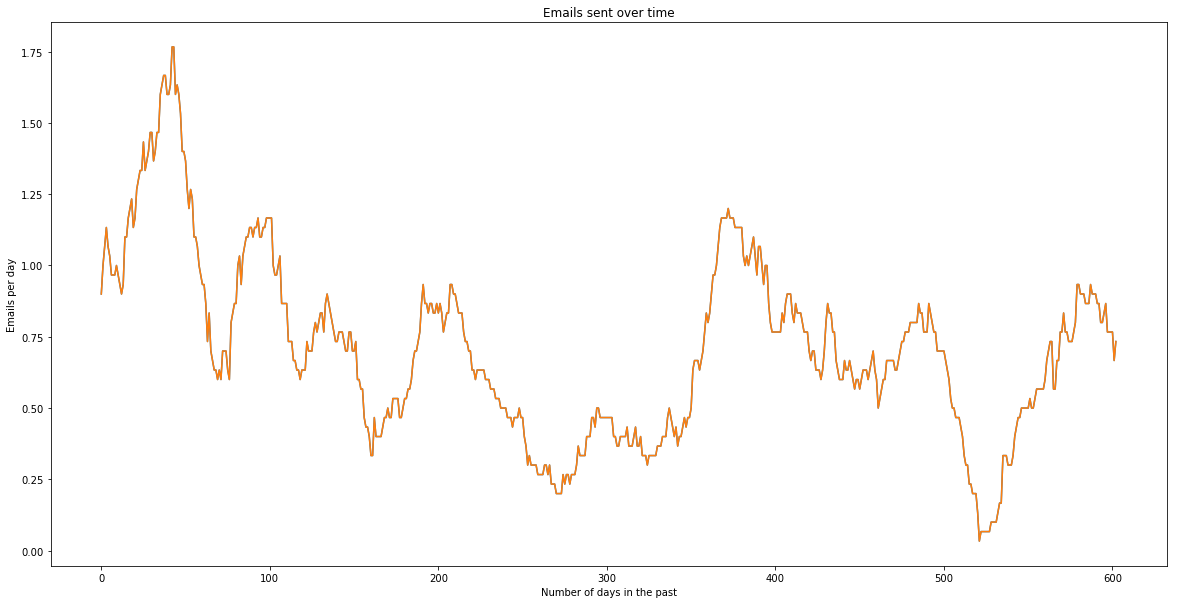

In [120]:
def data_to_days(dataset):
    min_date = dataset[-1][2]
    return [[x[0],x[1],(x[2]-min_date).days] for x in dataset]
raw_numbers = [x[2] for x in data_to_days(email_data)]
extrema = (raw_numbers[0],raw_numbers[-1])
freq_data = Counter(raw_numbers)
timelined = [freq_data[x] if x in freq_data else 0 for x in range(extrema[0]+1)]
### TODO: Implement exponential moving average
### https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
def rolling_average(dataset,size):
    work_from = dataset[size:]
    mean = lambda x: sum(x)/len(x)
    return [mean(dataset[i:i+size]) for i,x in enumerate(work_from)]
plt.rcParams['figure.figsize'] = (20,10)
plt.plot(rolling_average(timelined,30)[::-1]) # Makes the graph go back in time
plt.title('Emails sent over time')
plt.xlabel('Number of days in the past')
plt.ylabel('Emails per day')
plt.savefig('emails_over_time.png',bbox_inches='tight')
plt.show()

In [124]:
from datetime import timedelta
thirty_ma = rolling_average(timelined,30)[::-1]
print(thirty_ma.index(max(thirty_ma)))
date.today()-timedelta(days=42)

42


datetime.date(2018, 5, 6)